### Imports

In [1]:
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
from pathlib import Path

import velosearaptor

import piston_adcp_proc as pp

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Moored ADCP Processing

In [2]:
raw_data_dir = Path('../../data/raw/adcp/SIO2/SN14435/')
raw_data_files = sorted(raw_data_dir.glob('14435*'))
raw_data_files = [raw.as_posix() for raw in raw_data_files]

In [3]:
raw_data_files

['../../data/raw/adcp/SIO2/SN14435/14435000.000',
 '../../data/raw/adcp/SIO2/SN14435/14435001.000']

In [4]:
raw = velosearaptor.io.read_raw_rdi(raw_data_files)

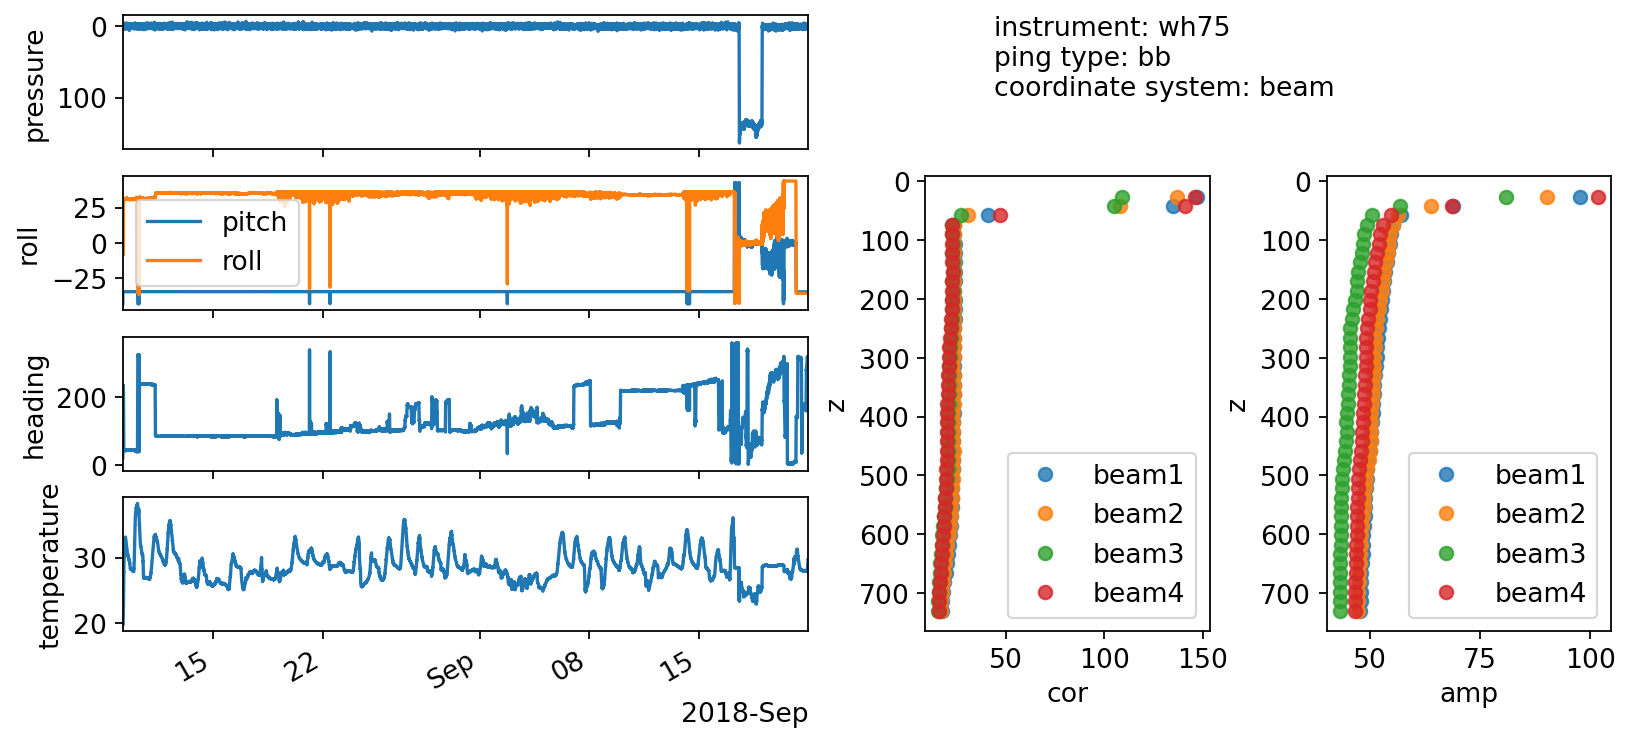

In [6]:
velosearaptor.adcp.plot_raw_adcp_auxillary(raw)

In [7]:
lat, lon = pp.mooring_location(2)

In [8]:
meta_data = {
    "mooring_id": "SIO2",
    "sn": 14435,
    "lon": lon,
    "lat": lat,
}
tgridparams = dict(burst_average=True)
editparams = dict()

Let the software figure out the best top and bottom limits and interval.

In [9]:
dgridparams = None

Here we provide the clock drift. Note that we are only working with a subset of the real ADCP data file to keep the file size small.

In [10]:
end_adcp = (2018,    9, 21,    23,   50,   28)
end_pc = (2018,    9,   21,    23,   49,   13)
driftparams = dict(end_pc=end_pc, end_adcp=end_adcp)

Set up a processing object. We will take care of the editing parameters in a little bit.

In [11]:
a = velosearaptor.madcp.ProcessADCP(
    raw_data_files[1],
    meta_data=meta_data,
    driftparams=driftparams,
    tgridparams=tgridparams,
    dgridparams=dgridparams,
    editparams=None,
    verbose=False,
)

No meta data provided, logging to generic filename 'adcp_proc.log'
No depth gridding parameters provided, using default values.
No edit parameters provided, using default values.


time between pings within burst: 3.0 s
time between bursts: 29.4 min
12 pings per burst
395 bursts total


We can see that the burst processing scheme was recognized. All parameters are stored as
attributes.

In [12]:
a.tgridparams

{'dt_hours': 0.5,
 't0': 255.7683356224973,
 't1': 263.97590684515734,
 'burst_average': True}

In [13]:
a.parse_tgridparams(tgridparams)

In [14]:
a.tgridparams

{'dt_hours': 0.5,
 't0': 255.7683356224973,
 't1': 263.97590684515734,
 'burst_average': True}

In [15]:
a.dgridparams

{'dtop': -5.0, 'dbot': 779.0, 'd_interval': 16.0}

Now we can start looking into the data.

Reading raw data...


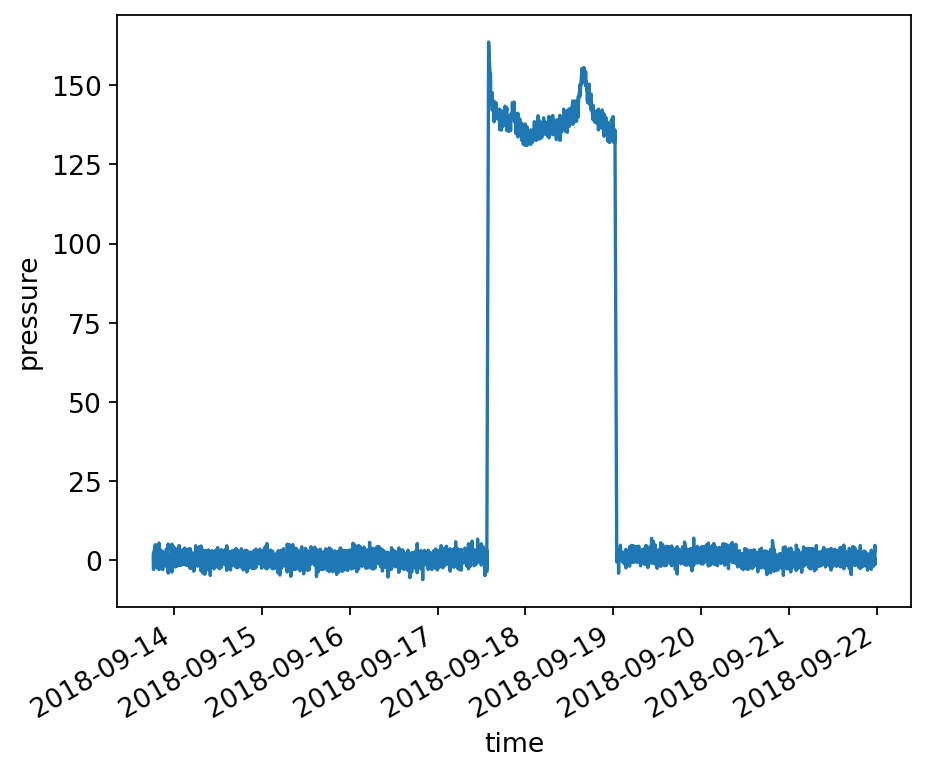

In [16]:
ax = a.raw.pressure.plot()

Magnetic declination. I think the little magdec command line tool must be installed for this, need to double check.

In [17]:
a.magdec

-1.631642

Run the burst averaging procedure without thinking about editing parameters for now.

In [18]:
a.burst_average_ensembles()

100%|███████████████████████████████████████████████████████████████████████| 395/395 [00:02<00:00, 188.72it/s]


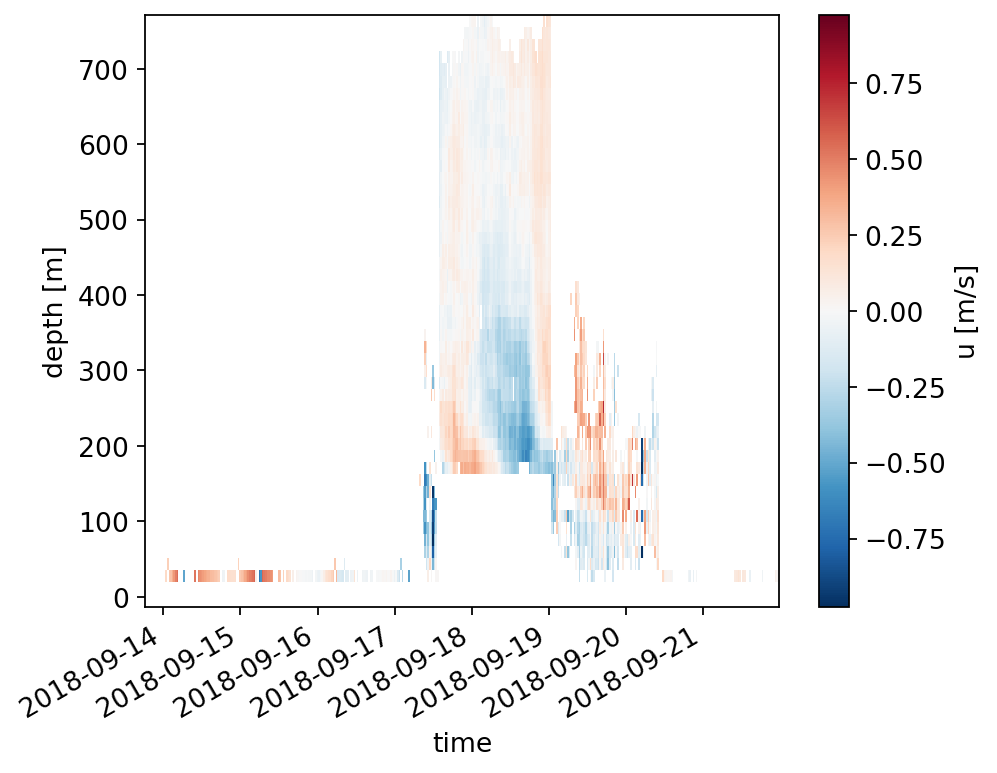

In [19]:
a.ds.u.plot()

Now we will refine the editing parameters. Let's look at beam statistics. We can see that the first bin may not be that good, and starting at bin 16 the beams hit the ocean bottom. Exclude these from the processing.

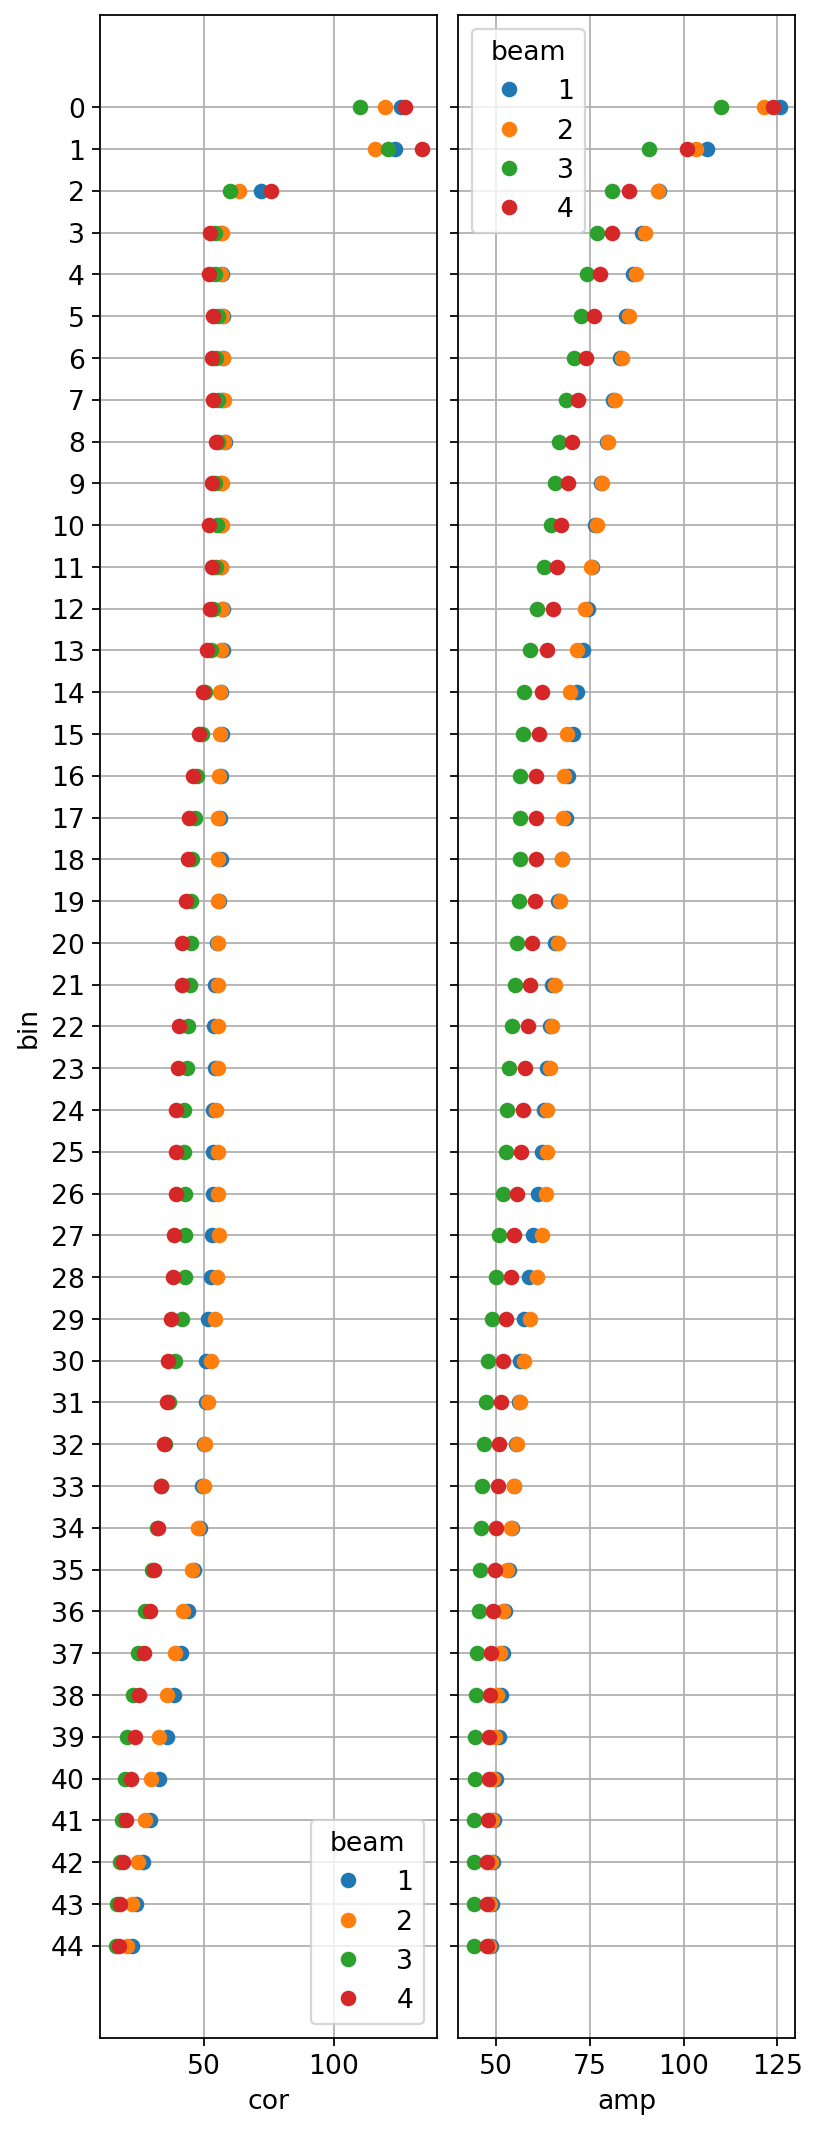

In [20]:
a.plot_echo_stats()

In [21]:
binmask = (a.raw.bin > 45).data
binmask[:1] = True

In [22]:
binmask

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

Feed the binmask into the editing parameters. Here we can also provide minimum correlation threshold for individual pings, a maximum error velocity, and a percent good threshold. Percent good is calculated for each average as the number of good data points (or pings) in each bin.

Once we have the dict with the editing parameters, we pass it on to the processing object.

In [23]:
editparams = dict(maskbins=binmask, min_correlation=40, max_e=0.2, pg_limit=50)
a.parse_editparams(editparams)

Let's double check the selected edit parameters:

In [24]:
a.editparams

{'max_e': 0.2,
 'max_e_deviation': 2,
 'min_correlation': 40,
 'maskbins': array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]),
 'pg_limit': 50}

In [25]:
np.flatnonzero(editparams['maskbins'])

array([0])

Run the burst averaging with the new editparams.

In [26]:
a.burst_average_ensembles()

100%|███████████████████████████████████████████████████████████████████████| 395/395 [00:02<00:00, 191.61it/s]


In [27]:
ds = a.ds.where(a.ds.pressure > 50, drop=True)

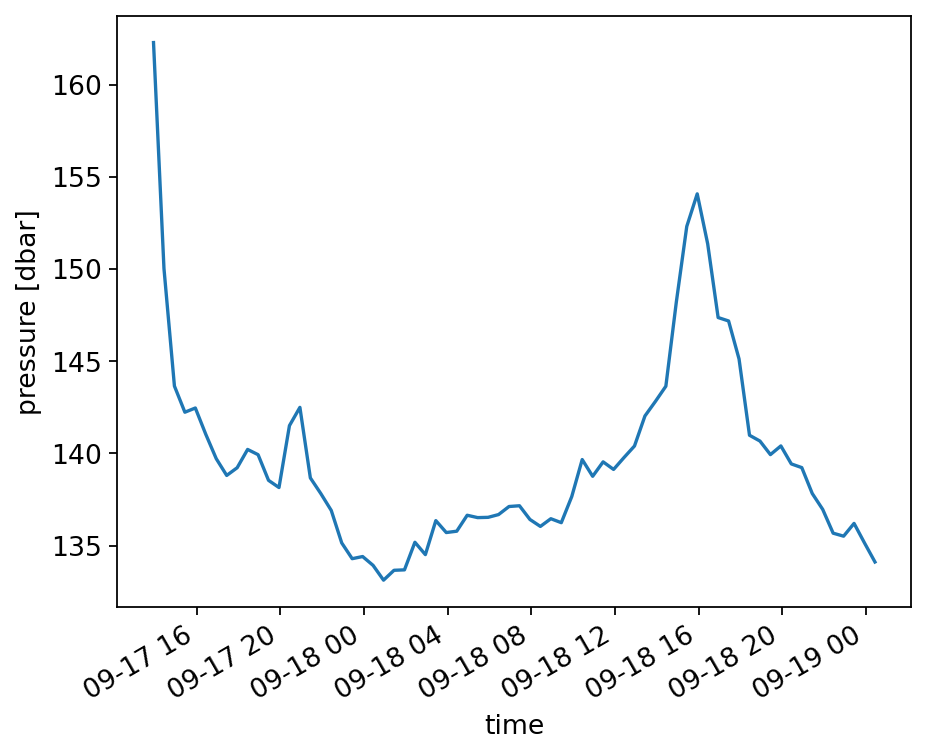

In [28]:
ds.pressure.plot()

In [30]:
ds = pp.adjust_variable_names(ds)

In [31]:
ds = pp.add_standard_meta_data(ds)

In [32]:
ds

<xarray.Dataset>
Dimensions:       (depth: 49, time: 70)
Coordinates:
  * time          (time) datetime64[ns] 2018-09-17T13:55:46.434876 ... 2018-0...
  * depth         (depth) float64 -5.0 11.0 27.0 43.0 ... 731.0 747.0 763.0
Data variables: (12/16)
    pg            (depth, time) float64 0.0 0.0 0.0 0.0 ... 83.0 96.0 100.0 93.0
    u             (depth, time) float32 nan nan nan nan ... 0.1551 0.1221 0.1246
    v             (depth, time) float32 nan nan nan ... -0.005895 -0.01031
    w             (depth, time) float32 nan nan nan ... -0.01277 0.01111
    e             (depth, time) float32 nan nan nan ... -0.01816 -0.01332
    u_std         (depth, time) float32 nan nan nan ... 0.1034 0.07251 0.06726
    ...            ...
    temperature   (time) float32 23.38 25.13 26.03 25.8 ... 25.16 25.38 25.42
    pressure      (time) float32 162.3 150.0 143.7 142.2 ... 136.2 135.1 134.1
    pressure_std  (time) float32 0.8451 1.936 1.394 1.693 ... 1.273 2.042 1.261
    pressure_max  (time) float32 163.6 153.6 147.6 145.0 ... 139.1 140.1 135.9
    npings        (time) float64 12.0 12.0 12.0 12.0 ... 12.0 12.0 12.0 12.0
    xducer_depth  (time) float64 161.3 149.1 142.8 141.4 ... 135.4 134.3 133.3
Attributes: (12/32)
    orientation:               down
    magdec:                    -1.631642
    max_e:                     0.2
    max_e_deviation:           2
    min_correlation:           40
    mooring_id:                SIO2
    ...                        ...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    geospatial_lat_units:      degree_north
    geospatial_lon_units:      degree_east
    start_time:                2018-09-17T13:55
    stop_time:                 2018-09-19T00:25

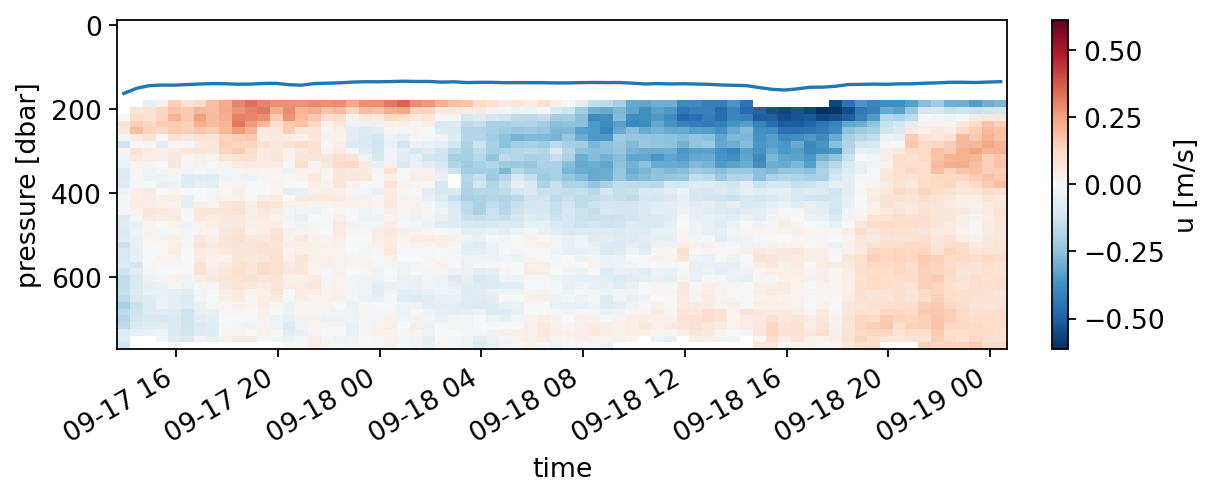

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 3),
                       constrained_layout=True)
ds.u.plot(ax=ax)
ds.pressure.plot(ax=ax)
ax.invert_yaxis()

Plot all raw data.

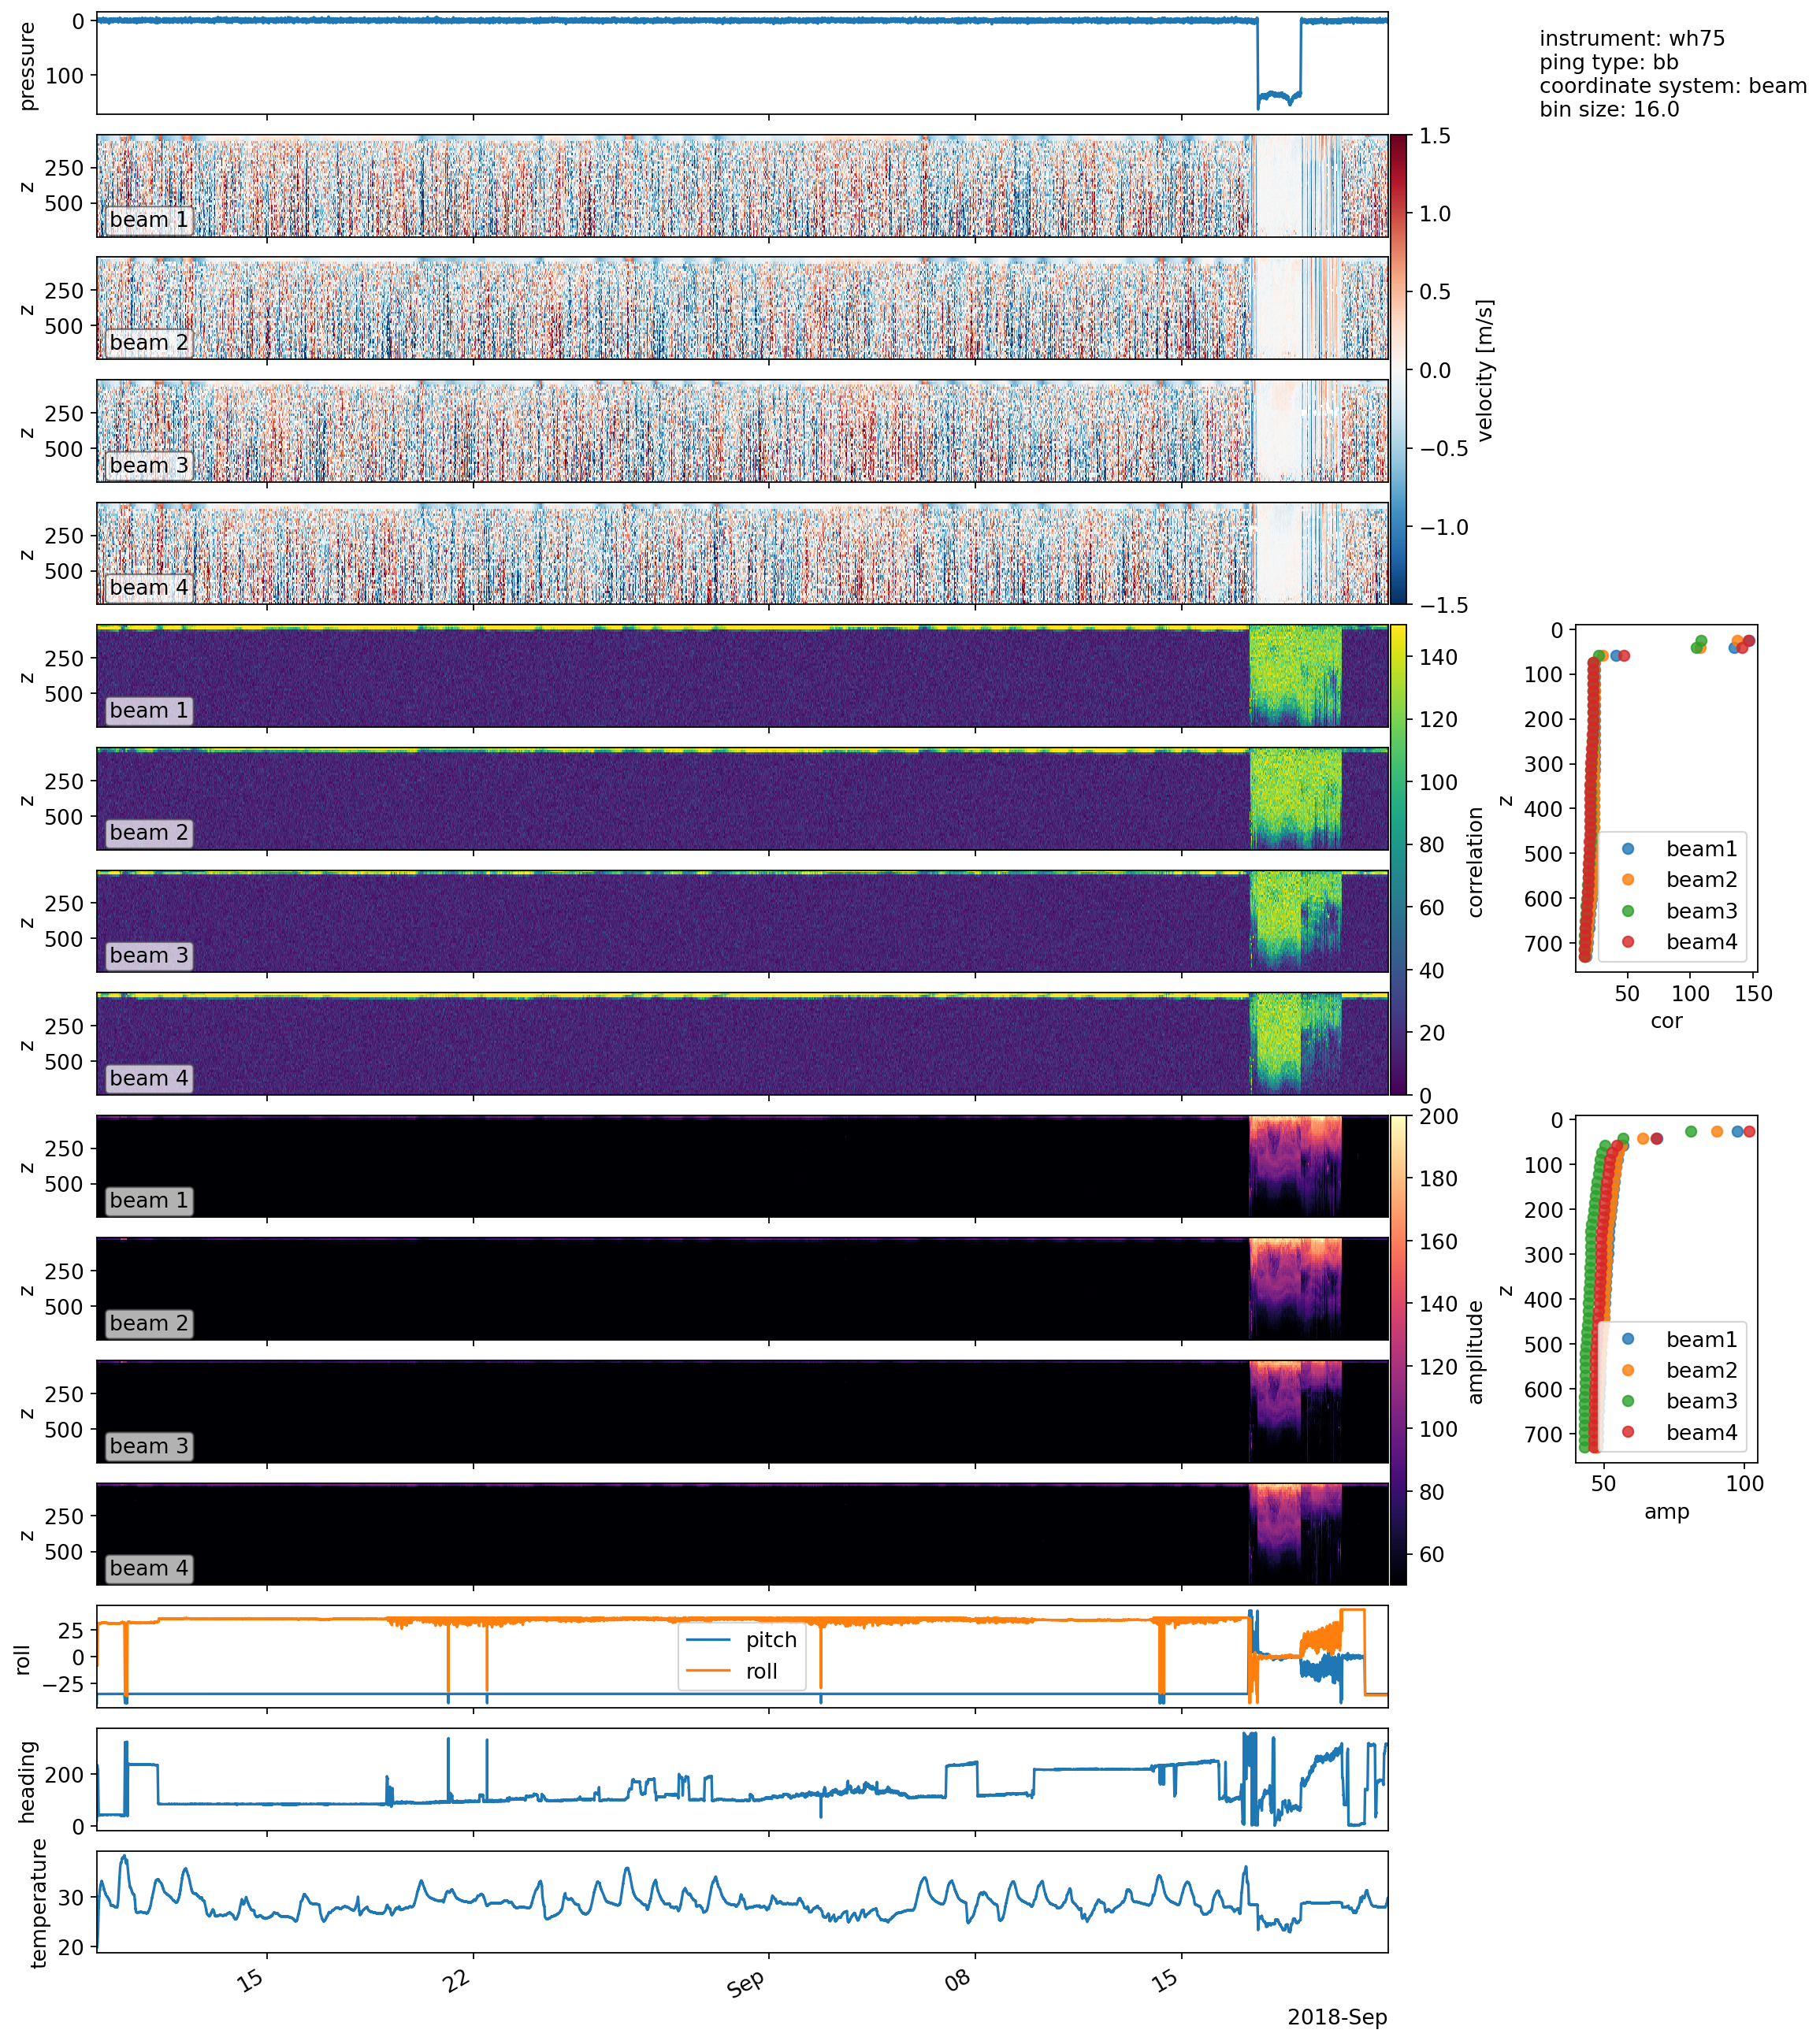

In [35]:
velosearaptor.adcp.plot_raw_adcp(raw)